In [1]:
from scipy.integrate import solve_ivp
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [14]:
import numpy as np
import pandas as pd

In [34]:
df = pd.read_csv('../3_Epidemiological_analysis/Covid19CasesGISAID.csv')
df = df[(df['Mutations'] == 'Lineage A') | (df['Mutations'] == 'Lineage B')]
df['Var1'] = pd.to_datetime(df['Var1'])
df = df[df['Var1'] < '2021-12-01']
df

,Var1,Freq,Mutations
0,2019-12-24,0,Lineage A
1,2019-12-25,0,Lineage A
2,2019-12-26,0,Lineage A
3,2019-12-27,0,Lineage A
4,2019-12-28,0,Lineage A
...,...,...,...
1718,2021-11-26,19624,Lineage B
1719,2021-11-27,13768,Lineage B
1720,2021-11-28,15233,Lineage B
1721,2021-11-29,33151,Lineage B


In [35]:
df1 = df
# Ensure no zero or negative values before applying log scale
df1['Freq'] = df1['Freq'].replace(0, np.nan)  # replace 0 with NaN to avoid log scale issues

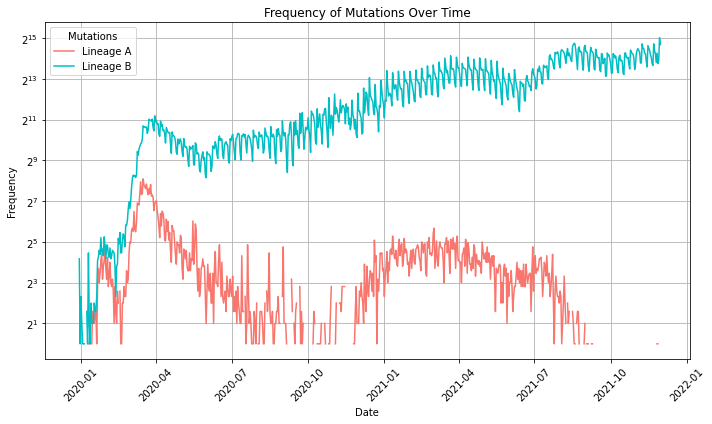

In [38]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

color_map = {
    'Lineage A': '#f8766d',
    'Lineage B': '#00bfc4'
}

# Group data by 'Mutations' and plot each group
for label, grp in df1.groupby('Mutations'):
    ax.plot(grp['Var1'], grp['Freq'], label=label, color=color_map[label])

# Set the y-axis to log2 scale
ax.set_yscale('log', base=2)
# Formatting the plot
ax.set_xlabel('Date')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Mutations Over Time')
ax.legend(title='Mutations')
ax.grid(True)

# Rotate date labels for better visibility
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated date labels

# Show the plot
plt.show()


In [6]:
# Define the across-host model
def across_host_model(t, y, beta1, beta2, gamma, N):
    S, I1, I2, R = y
    dS_dt = - beta1 * S * I1 / N - beta2 * S * I2 / N
    dI1_dt = beta1 * S * I1 / N - gamma * I1
    dI2_dt = beta2 * S * I2 / N - gamma * I2
    dR_dt = gamma * I1 + gamma * I2
    return [dS_dt, dI1_dt, dI2_dt, dR_dt]


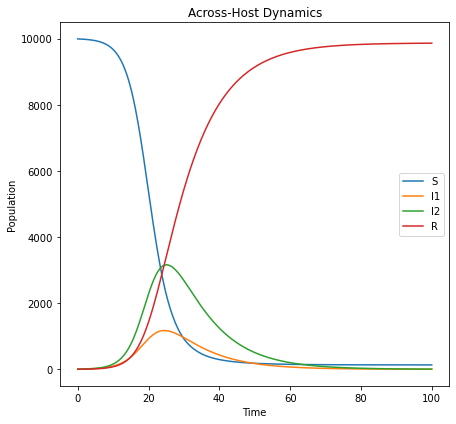

In [13]:
# Initial conditions and parameters for simulation
params_across_host = {'beta1': 0.4, 'beta2': 0.45, 'gamma': 0.1, 'N': 10000}
y0_across_host = [9990, 5, 5, 0]
t_span = (0, 100)
t_eval = np.linspace(0, 100, 400)

# Solve the differential equations
sol_across_host = solve_ivp(across_host_model, t_span, y0_across_host, \
                            args=(params_across_host['beta1'], params_across_host['beta2'], \
                                  params_across_host['gamma'], params_across_host['N']), \
                            t_eval=t_eval)

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(122)
plt.plot(sol_across_host.t, sol_across_host.y[0], label='S')
plt.plot(sol_across_host.t, sol_across_host.y[1], label='I1')
plt.plot(sol_across_host.t, sol_across_host.y[2], label='I2')
plt.plot(sol_across_host.t, sol_across_host.y[3], label='R')
plt.title('Across-Host Dynamics')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:

# Bayesian estimation (simplified example using synthetic data and pymc3)
with pm.Model() as model:
    # Priors for parameters based on hypothetical prior knowledge
    beta1 = pm.Normal('beta1', mu=0.4, sigma=0.1)
    gamma1 = pm.Normal('gamma1', mu=0.1, sigma=0.05)

    # Likelihood (using synthetic data)
    I1_observed = sol_across_host.y[1] + np.random.normal(0, 10, size=len(sol_across_host.t))
    I1_likelihood = pm.Normal('I1_likelihood', mu=beta1 * sol_across_host.y[0] * sol_across_host.y[1] / params_across_host['N'] - gamma1 * sol_across_host.y[1], sigma=10, observed=I1_observed)

    # Inference
    trace = pm.sample(500, return_inferencedata=False)

# Plot posterior estimates
az.plot_posterior(trace)
plt.show()